In [249]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy.stats as st
import os
import numpy as np
import random
from scipy.stats import linregress
from scipy.stats import pearsonr
import hvplot.pandas
import requests

In [251]:
movie_df = pd.read_csv('movies_awards.csv')
movie_df.shape

(5453, 21)

In [252]:
clean_movie_df = movie_df.copy()

In [272]:
clean_movie_df.head(5)

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre,...,Language,Rotten Tomatoes Rating,IMDb Rating,Metascore,Box Office,imdbID,Oscar Awards,Oscar Nominations,Award Wins,Award Nominations
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,534860000.0,Action,"Crime, Drama",...,"English, Mandarin",0.94,9.0,84.0,"$534,987,076",tt0468569,2.0,8.0,163.0,164.0
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,377850000.0,Action,"Adventure, Drama",...,"English, Quenya, Old English, Sindarin",0.94,9.0,94.0,"$379,427,292",tt0167260,11.0,11.0,215.0,124.0
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,292580000.0,Action,"Adventure, Sci-Fi",...,"English, Japanese, French",0.87,8.8,74.0,"$292,587,330",tt1375666,4.0,8.0,159.0,220.0
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,342550000.0,Action,"Adventure, Drama",...,"English, Sindarin, Old English",0.95,8.8,87.0,"$342,952,511",tt0167261,2.0,6.0,132.0,138.0
5,The Lord of the Rings: The Fellowship of the Ring,2001,Peter Jackson,"Elijah Wood, Ian McKellen, Orlando Bloom, Sean...",8.8,178,U,315540000.0,Action,"Adventure, Drama",...,"English, Sindarin",0.91,8.9,92.0,"$316,115,420",tt0120737,4.0,13.0,125.0,127.0


In [254]:
def convert_money(value):
    if 'M' in value:
        return float(value.replace('$', '').replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('$', '').replace('B', '')) * 1e9
    return np.nan

# Apply conversion to the 'gross_total' column
clean_movie_df['Total_Gross'] = clean_movie_df['Total_Gross'].apply(lambda x: convert_money(x) if isinstance(x, str) and '$' in x else np.nan)

print(clean_movie_df)

                                        Movie_Title  Year  \
0                                           Kantara  2022   
1                                   The Dark Knight  2008   
2     The Lord of the Rings: The Return of the King  2003   
3                                         Inception  2010   
4             The Lord of the Rings: The Two Towers  2002   
...                                             ...   ...   
5448                                 Disaster Movie  2008   
5449                        The Hottie & the Nottie  2008   
5450                           From Justin to Kelly  2003   
5451                   Superbabies: Baby Geniuses 2  2004   
5452                 Cumali Ceber: Allah Seni Alsin  2017   

                                      Director  \
0                                Rishab Shetty   
1                            Christopher Nolan   
2                                Peter Jackson   
3                            Christopher Nolan   
4                

In [261]:
clean_movie_df.dropna(subset=['Total_Gross'], inplace=True)
# clean_movie_df.dropna()
# Print the cleaned DataFrame
print(clean_movie_df)

                                            Movie_Title  Year  \
1                                       The Dark Knight  2008   
2         The Lord of the Rings: The Return of the King  2003   
3                                             Inception  2010   
4                 The Lord of the Rings: The Two Towers  2002   
5     The Lord of the Rings: The Fellowship of the Ring  2001   
...                                                 ...   ...   
5446                                    Son of the Mask  2005   
5448                                     Disaster Movie  2008   
5449                            The Hottie & the Nottie  2008   
5450                               From Justin to Kelly  2003   
5451                       Superbabies: Baby Geniuses 2  2004   

                                      Director  \
1                            Christopher Nolan   
2                                Peter Jackson   
3                            Christopher Nolan   
4                  

In [262]:
clean_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4609 entries, 1 to 5451
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Movie_Title             4609 non-null   object 
 1   Year                    4609 non-null   int64  
 2   Director                4609 non-null   object 
 3   Actors                  4609 non-null   object 
 4   Rating                  4609 non-null   float64
 5   Runtime(Mins)           4609 non-null   int64  
 6   Censor                  4609 non-null   object 
 7   Total_Gross             4609 non-null   float64
 8   main_genre              4609 non-null   object 
 9   side_genre              4609 non-null   object 
 10  Movie Rated             4595 non-null   object 
 11  Language                4608 non-null   object 
 12  Rotten Tomatoes Rating  758 non-null    float64
 13  IMDb Rating             782 non-null    float64
 14  Metascore               738 non-null    float

In [263]:
clean_movie_df['Total_Gross'] = pd.to_numeric(clean_movie_df['Total_Gross'], errors='coerce')
print(clean_movie_df.dtypes)

Movie_Title                object
Year                        int64
Director                   object
Actors                     object
Rating                    float64
Runtime(Mins)               int64
Censor                     object
Total_Gross               float64
main_genre                 object
side_genre                 object
Movie Rated                object
Language                   object
Rotten Tomatoes Rating    float64
IMDb Rating               float64
Metascore                 float64
Box Office                 object
imdbID                     object
Oscar Awards              float64
Oscar Nominations         float64
Award Wins                float64
Award Nominations         float64
dtype: object


In [265]:
print("NaNs in award_noms_x:", award_noms_x.isna().sum())
print("NaNs in total_gross_y:", total_gross_y.isna().sum())
print("Infs in award_noms_x:", np.isinf(award_noms_x).sum())
print("Infs in total_gross_y:", np.isinf(total_gross_y).sum())

NaNs in award_noms_x: 0
NaNs in total_gross_y: 844
Infs in award_noms_x: 0
Infs in total_gross_y: 0


The r-value is: PearsonRResult(statistic=0.4512468471756939, pvalue=4.379961688481138e-230)


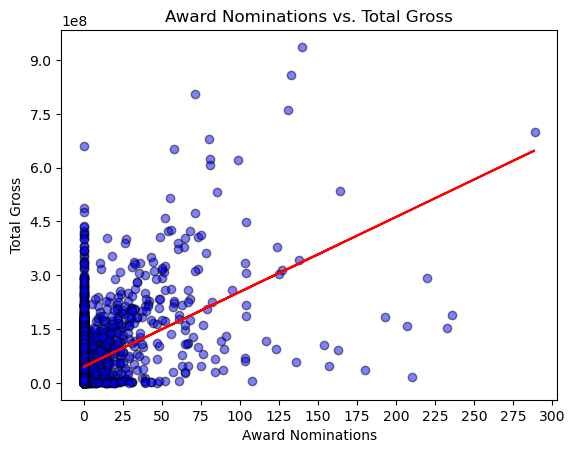

In [266]:
# Define my x and y axis
award_noms_x = clean_movie_df['Award Nominations']
total_gross_y = clean_movie_df['Total_Gross']

# Correlation
correlation = st.pearsonr(award_noms_x, total_gross_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(award_noms_x, total_gross_y)
regress_values = award_noms_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(award_noms_x, total_gross_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(award_noms_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Nominations vs. Total Gross')
plt.xlabel('Award Nominations')
plt.ylabel('Total Gross')
plt.grid(False)

print(f'The r-value is: {correlation}')

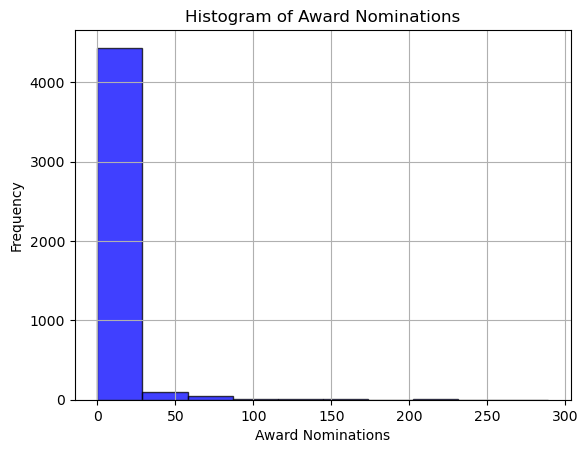

In [267]:
clean_movie_df['Award Nominations'].plot(kind='hist', bins=10, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Award Nominations')
plt.xlabel('Award Nominations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

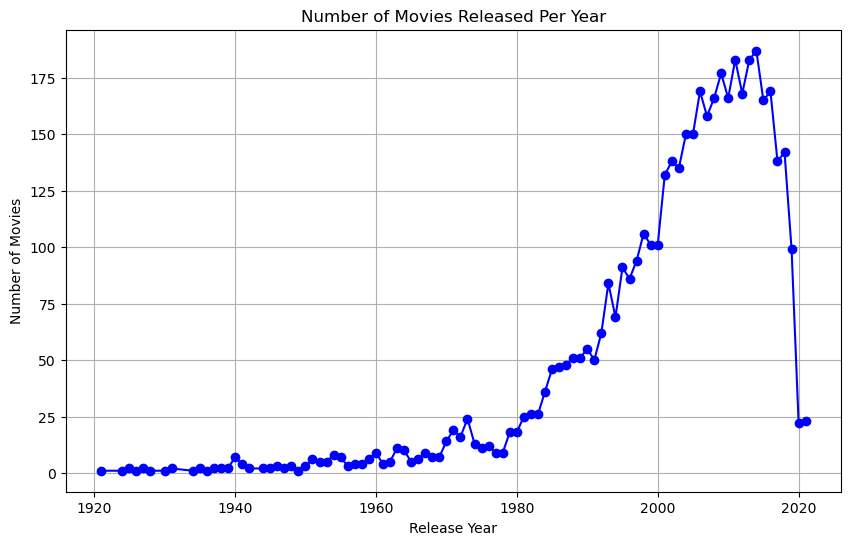

In [268]:
yearly_movies = clean_movie_df['Year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(yearly_movies.index, yearly_movies.values, marker='o', linestyle='-', color='b')  # Create line graph
plt.title('Number of Movies Released Per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.grid(True)  # Enable grid for better readability
plt.show()

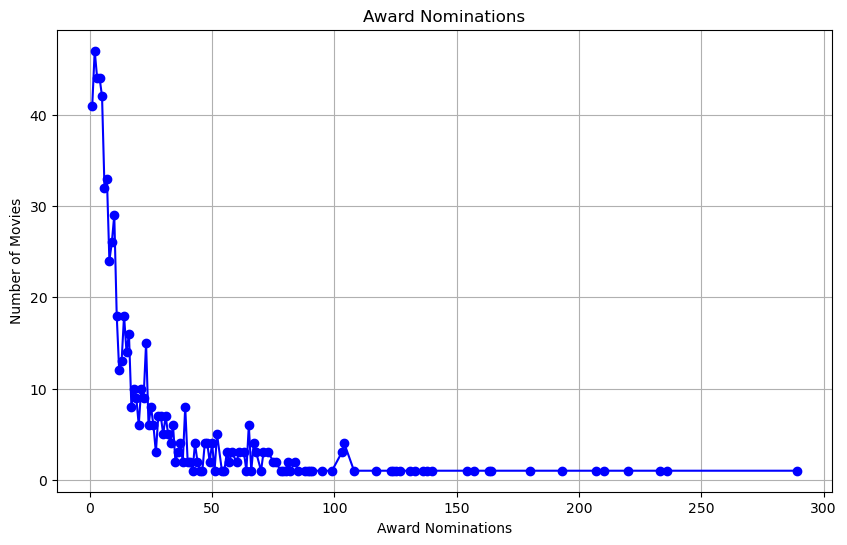

In [269]:
yearly_movies = clean_movie_df['Award Nominations'].value_counts().sort_index()
yearly_movies = yearly_movies[yearly_movies.index != 0]
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(yearly_movies.index, yearly_movies.values, marker='o', linestyle='-', color='b')  # Create line graph
plt.title('Award Nominations')
plt.xlabel('Award Nominations')
plt.ylabel('Number of Movies')
plt.grid(True)  # Enable grid for better readability
plt.show()

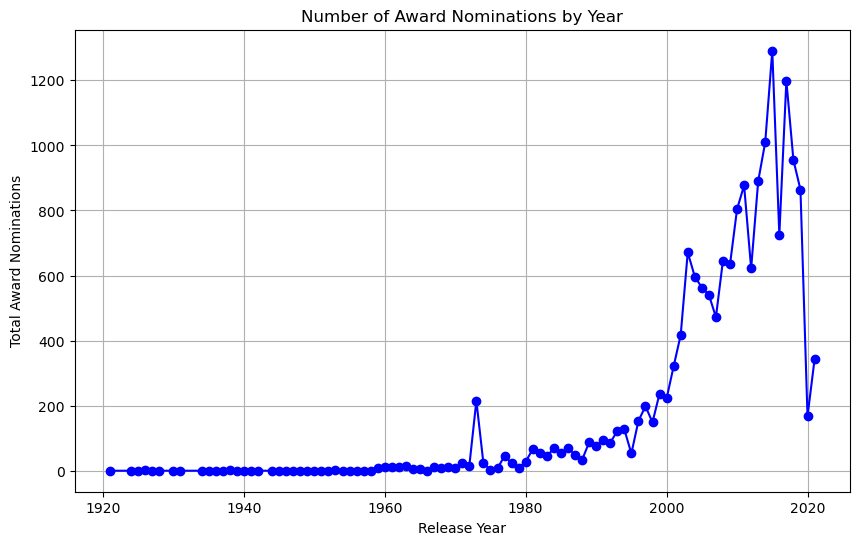

In [270]:
nominations_by_year = clean_movie_df.groupby('Year')['Award Nominations'].sum()

# Reset index to make 'Release Year' a column again for easier plotting
nominations_by_year = nominations_by_year.reset_index()
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(nominations_by_year['Year'], nominations_by_year['Award Nominations'], marker='o', linestyle='-', color='b')
plt.title('Number of Award Nominations by Year')
plt.xlabel('Release Year')
plt.ylabel('Total Award Nominations')
plt.grid(True)  # Enable grid for better readability
plt.show()

In [273]:
clean_movie_df.to_csv('movies_awards_2.csv', index=False) 